In [8]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Spatial analysis
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.spatial.distance import cdist

# Mapping
import folium
from folium import plugins
import plotly.express as px
import plotly.graph_objects as go

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [9]:
def load_all_datasets():
    """Load all datasets from CSV files"""
    
    # Load processed data
    bike_data = pd.read_csv('../data/processed/bike_counters_processed.csv')
    pedestrian_data = pd.read_csv('../data/processed/pedestrian_zones_processed.csv')
    panels_data = pd.read_csv('../data/processed/panels_processed.csv')
    
    # Load additional analysis files if needed
    try:
        panel_infrastructure = pd.read_csv('../data/processed/panel_infrastructure_analysis.csv')
    except:
        panel_infrastructure = None
        print("Panel infrastructure analysis file not found")
    
    print(f"Loaded datasets:")
    print(f"  - Bike counters: {len(bike_data):,} records")
    print(f"  - Pedestrian zones: {len(pedestrian_data):,} records")
    print(f"  - Panels: {len(panels_data):,} records")
    
    # Display columns for each dataset
    print("\nColumns in each dataset:")
    print(f"Bike data: {list(bike_data.columns)}")
    print(f"Pedestrian data: {list(pedestrian_data.columns)}")
    print(f"Panels data: {list(panels_data.columns)}")
    
    return bike_data, pedestrian_data, panels_data

# Load all data
bike_data, pedestrian_data, panels_data = load_all_datasets()

Loaded datasets:
  - Bike counters: 10,000 records
  - Pedestrian zones: 626 records
  - Panels: 287 records

Columns in each dataset:
Bike data: ['counter_name', 'installation_date', 'count_datetime', 'hourly_count', 'coordinates', 'month_year', 'id_compteur', 'counter', 'name', 'id', 'arrondissement', 'year', 'month', 'day', 'hour', 'weekday', 'arrondissement_clean', 'latitude', 'longitude', 'date', 'week', 'is_rush_hour', 'is_weekend']
Pedestrian data: ['zone_name', 'arrondissement', 'date_partition_bovp', 'geo_shape', 'geo_point_2d', 'is_named', 'arrondissement_clean', 'data_quality', 'has_coordinates', 'has_date', 'latitude', 'longitude']
Panels data: ['location', 'precision', 'arrondissement', 'format_1m2', 'format_2m2', 'coordinates', 'geometry', 'arr_raw', 'arr_extracted', 'arrondissement_clean', 'total_panels', 'total_area', 'latitude', 'longitude']


In [10]:
# Ensure datetime columns are properly formatted
if 'count_datetime' in bike_data.columns:
    bike_data['count_datetime'] = pd.to_datetime(bike_data['count_datetime'])
    bike_data['hour'] = bike_data['count_datetime'].dt.hour
    bike_data['day_of_week'] = bike_data['count_datetime'].dt.dayofweek
    bike_data['weekday'] = bike_data['count_datetime'].dt.day_name()

# Check for coordinate columns and create them if missing
print("Checking coordinate columns...")

# For bike data
if 'latitude' not in bike_data.columns or 'longitude' not in bike_data.columns:
    # Try to get coordinates from counter_name or other columns
    print("Warning: No latitude/longitude columns in bike data")
    # Create dummy coordinates for now (you should update this with real coordinates)
    bike_data['latitude'] = np.nan
    bike_data['longitude'] = np.nan

# For pedestrian data
if 'latitude' not in pedestrian_data.columns or 'longitude' not in pedestrian_data.columns:
    print("Warning: No latitude/longitude columns in pedestrian data")
    pedestrian_data['latitude'] = np.nan
    pedestrian_data['longitude'] = np.nan

# For panels data
if 'latitude' not in panels_data.columns or 'longitude' not in panels_data.columns:
    print("Warning: No latitude/longitude columns in panels data")
    panels_data['latitude'] = np.nan
    panels_data['longitude'] = np.nan

# Ensure is_named column exists in pedestrian data
if 'is_named' not in pedestrian_data.columns:
    if 'zone_name' in pedestrian_data.columns:
        pedestrian_data['is_named'] = pedestrian_data['zone_name'].notna()
    else:
        pedestrian_data['is_named'] = False

# Ensure total_panels and total_area columns exist
if 'total_panels' not in panels_data.columns:
    if 'format_1m2' in panels_data.columns and 'format_2m2' in panels_data.columns:
        panels_data['format_1m2'] = pd.to_numeric(panels_data['format_1m2'], errors='coerce').fillna(0)
        panels_data['format_2m2'] = pd.to_numeric(panels_data['format_2m2'], errors='coerce').fillna(0)
        panels_data['total_panels'] = panels_data['format_1m2'] + panels_data['format_2m2']
        panels_data['total_area'] = panels_data['format_1m2'] + panels_data['format_2m2'] * 2
    else:
        panels_data['total_panels'] = 1  # Assume 1 panel per record
        panels_data['total_area'] = 2    # Assume 2m² average

print("\nData preparation complete!")
print(f"Bike data with coordinates: {bike_data['latitude'].notna().sum()}")
print(f"Pedestrian data with coordinates: {pedestrian_data['latitude'].notna().sum()}")
print(f"Panels data with coordinates: {panels_data['latitude'].notna().sum()}")

Checking coordinate columns...

Data preparation complete!
Bike data with coordinates: 10000
Pedestrian data with coordinates: 626
Panels data with coordinates: 285


In [11]:
def create_hex_grid_analysis(lat_min=48.815, lat_max=48.902, lon_min=2.225, lon_max=2.420, hex_size=0.005):
    """Create hexagonal grid for Paris"""
    
    hex_centers = []
    lat_step = hex_size * 0.866  # sqrt(3)/2 for hexagon height
    lon_step = hex_size * 1.5
    
    row = 0
    current_lat = lat_min
    while current_lat <= lat_max:
        current_lon = lon_min + (row % 2) * (lon_step / 2)
        while current_lon <= lon_max:
            hex_centers.append({
                'hex_id': f"hex_{row}_{int((current_lon-lon_min)/lon_step)}",
                'lat': current_lat,
                'lon': current_lon,
                'row': row,
                'col': int((current_lon-lon_min)/lon_step)
            })
            current_lon += lon_step
        current_lat += lat_step
        row += 1
    
    hex_df = pd.DataFrame(hex_centers)
    print(f"Created {len(hex_df)} hexagons covering Paris")
    
    return hex_df

def assign_to_hex(df, hex_df, lat_col='latitude', lon_col='longitude'):
    """Assign data points to nearest hexagon"""
    
    # Create a copy to avoid modifying original
    df = df.copy()
    
    # Initialize hex columns
    df['hex_id'] = None
    df['hex_lat'] = np.nan
    df['hex_lon'] = np.nan
    
    # Get rows with valid coordinates
    valid_mask = df[lat_col].notna() & df[lon_col].notna()
    valid_indices = df[valid_mask].index
    
    if len(valid_indices) == 0:
        print(f"No valid coordinates found in columns {lat_col}, {lon_col}")
        return df
    
    # Get coordinates
    data_coords = df.loc[valid_indices, [lat_col, lon_col]].values
    hex_coords = hex_df[['lat', 'lon']].values
    
    # Calculate distances and find nearest hex
    distances = cdist(data_coords, hex_coords)
    nearest_hex_idx = distances.argmin(axis=1)
    
    # Assign hex information
    df.loc[valid_indices, 'hex_id'] = hex_df.iloc[nearest_hex_idx]['hex_id'].values
    df.loc[valid_indices, 'hex_lat'] = hex_df.iloc[nearest_hex_idx]['lat'].values
    df.loc[valid_indices, 'hex_lon'] = hex_df.iloc[nearest_hex_idx]['lon'].values
    
    print(f"Assigned {len(valid_indices)} records to hexagons")
    
    return df

# Create hexagonal grid
hex_grid = create_hex_grid_analysis()

# Assign data to hexagons
print("\nAssigning data to hexagonal grid...")
bike_data = assign_to_hex(bike_data, hex_grid)
pedestrian_data = assign_to_hex(pedestrian_data, hex_grid)
panels_data = assign_to_hex(panels_data, hex_grid)

print("\nHexagonal grid assignment complete!")

Created 557 hexagons covering Paris

Assigning data to hexagonal grid...
Assigned 10000 records to hexagons
Assigned 626 records to hexagons
Assigned 285 records to hexagons

Hexagonal grid assignment complete!


In [12]:
def calculate_hex_activity_scores(bike_data, pedestrian_data, panels_data, hex_grid):
    """Calculate comprehensive activity scores for each hexagon"""
    
    # Start with hex grid as base
    hex_activity = hex_grid.copy()
    
    # Initialize columns
    hex_activity['bike_records'] = 0
    hex_activity['bike_peak_hour'] = 0
    hex_activity['rush_hour_ratio'] = 0
    hex_activity['pedestrian_zones'] = 0
    hex_activity['named_zones'] = 0
    hex_activity['zone_quality'] = 0
    hex_activity['total_panels'] = 0
    hex_activity['total_area'] = 0
    
    # Aggregate bike data if hex_id exists
    if 'hex_id' in bike_data.columns and bike_data['hex_id'].notna().any():
        bike_agg = bike_data[bike_data['hex_id'].notna()].groupby('hex_id').agg({
            'hex_id': 'count'
        }).rename(columns={'hex_id': 'bike_records'})
        
        # Calculate rush hour ratio if hour column exists
        if 'hour' in bike_data.columns:
            rush_hours = [7, 8, 9, 17, 18, 19]
            rush_data = bike_data[bike_data['hour'].isin(rush_hours) & bike_data['hex_id'].notna()]
            rush_counts = rush_data.groupby('hex_id').size()
            total_counts = bike_data[bike_data['hex_id'].notna()].groupby('hex_id').size()
            rush_ratio = (rush_counts / total_counts).fillna(0)
            
            bike_agg['rush_hour_ratio'] = rush_ratio
            
            # Get peak hour
            peak_hours = bike_data[bike_data['hex_id'].notna()].groupby('hex_id')['hour'].agg(
                lambda x: x.mode()[0] if len(x) > 0 else 0
            )
            bike_agg['bike_peak_hour'] = peak_hours
        
        # Merge bike aggregations
        hex_activity = hex_activity.merge(bike_agg, left_on='hex_id', right_index=True, how='left', suffixes=('', '_bike'))
        
        # Update columns
        for col in ['bike_records', 'rush_hour_ratio', 'bike_peak_hour']:
            if col + '_bike' in hex_activity.columns:
                hex_activity[col] = hex_activity[col + '_bike'].fillna(0)
                hex_activity = hex_activity.drop(columns=[col + '_bike'])
    
    # Aggregate pedestrian data
    if 'hex_id' in pedestrian_data.columns and pedestrian_data['hex_id'].notna().any():
        ped_agg = pedestrian_data[pedestrian_data['hex_id'].notna()].groupby('hex_id').agg({
            'hex_id': 'count',
            'is_named': 'sum'
        }).rename(columns={'hex_id': 'pedestrian_zones', 'is_named': 'named_zones'})
        
        ped_agg['zone_quality'] = (ped_agg['named_zones'] / ped_agg['pedestrian_zones']).fillna(0)
        
        # Merge pedestrian aggregations
        hex_activity = hex_activity.merge(ped_agg, left_on='hex_id', right_index=True, how='left', suffixes=('', '_ped'))
        
        # Update columns
        for col in ['pedestrian_zones', 'named_zones', 'zone_quality']:
            if col + '_ped' in hex_activity.columns:
                hex_activity[col] = hex_activity[col + '_ped'].fillna(0)
                hex_activity = hex_activity.drop(columns=[col + '_ped'])
    
    # Aggregate panel data
    if 'hex_id' in panels_data.columns and panels_data['hex_id'].notna().any():
        panel_agg = panels_data[panels_data['hex_id'].notna()].groupby('hex_id').agg({
            'total_panels': 'sum',
            'total_area': 'sum'
        })
        
        # Merge panel aggregations
        hex_activity = hex_activity.merge(panel_agg, left_on='hex_id', right_index=True, how='left', suffixes=('', '_panel'))
        
        # Update columns
        for col in ['total_panels', 'total_area']:
            if col + '_panel' in hex_activity.columns:
                hex_activity[col] = hex_activity[col + '_panel'].fillna(0)
                hex_activity = hex_activity.drop(columns=[col + '_panel'])
    
    # Fill any remaining NaN values
    numeric_cols = ['bike_records', 'rush_hour_ratio', 'bike_peak_hour', 'pedestrian_zones', 
                    'named_zones', 'zone_quality', 'total_panels', 'total_area']
    for col in numeric_cols:
        hex_activity[col] = hex_activity[col].fillna(0)
    
    # Normalize scores (0-1 scale)
    for col in ['bike_records', 'pedestrian_zones', 'total_panels']:
        if hex_activity[col].max() > 0:
            hex_activity[f'{col}_norm'] = hex_activity[col] / hex_activity[col].max()
        else:
            hex_activity[f'{col}_norm'] = 0
    
    return hex_activity

# Calculate activity scores
hex_activity = calculate_hex_activity_scores(bike_data, pedestrian_data, panels_data, hex_grid)
print(f"Calculated activity scores for {len(hex_activity)} hexagons")

# Show summary of active hexagons
active_hexagons = hex_activity[
    (hex_activity['bike_records'] > 0) | 
    (hex_activity['pedestrian_zones'] > 0) | 
    (hex_activity['total_panels'] > 0)
]
print(f"Active hexagons (with any data): {len(active_hexagons)}")
print(f"  - With bike data: {len(hex_activity[hex_activity['bike_records'] > 0])}")
print(f"  - With pedestrian data: {len(hex_activity[hex_activity['pedestrian_zones'] > 0])}")
print(f"  - With panel data: {len(hex_activity[hex_activity['total_panels'] > 0])}")

Calculated activity scores for 557 hexagons
Active hexagons (with any data): 273
  - With bike data: 3
  - With pedestrian data: 231
  - With panel data: 173


In [13]:
def calculate_opportunity_score(hex_activity):
    """Calculate comprehensive opportunity score for each hexagon"""
    
    df = hex_activity.copy()
    
    # 1. Activity Score (40% weight)
    df['activity_score'] = (
        df['bike_records_norm'] * 0.4 +
        df['pedestrian_zones_norm'] * 0.3 +
        df['zone_quality'] * 0.3
    )
    
    # 2. Infrastructure Gap Score (30% weight)
    df['has_activity'] = ((df['bike_records'] > 0) | (df['pedestrian_zones'] > 0)).astype(int)
    df['infrastructure_gap'] = df['has_activity'] * (1 - df['total_panels_norm'])
    
    # 3. Accessibility Score (20% weight)
    df['accessibility_score'] = df['zone_quality']
    
    # 4. Temporal Value Score (10% weight)
    df['temporal_score'] = df['rush_hour_ratio']
    
    # Calculate final opportunity score
    df['opportunity_score'] = (
        df['activity_score'] * 0.4 +
        df['infrastructure_gap'] * 0.3 +
        df['accessibility_score'] * 0.2 +
        df['temporal_score'] * 0.1
    )
    
    # Rank hexagons
    df['opportunity_rank'] = df['opportunity_score'].rank(ascending=False, method='dense')
    
    # Categorize opportunities
    df['opportunity_category'] = pd.cut(
        df['opportunity_score'],
        bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
        labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
    )
    
    return df

# Calculate opportunity scores
hex_opportunity = calculate_opportunity_score(hex_activity)

# Display top opportunities
if hex_opportunity['has_activity'].sum() > 0:
    top_opportunities = hex_opportunity[hex_opportunity['has_activity'] == 1].nlargest(20, 'opportunity_score')
    print("\nTOP 20 COMMERCIAL OPPORTUNITIES:")
    print("=" * 80)
    for idx, row in top_opportunities.iterrows():
        print(f"Hex {row['hex_id']}:")
        print(f"  Location: ({row['lat']:.4f}, {row['lon']:.4f})")
        print(f"  Opportunity Score: {row['opportunity_score']:.3f}")
        print(f"  Bike Activity: {row['bike_records']:.0f} records")
        print(f"  Pedestrian Zones: {row['pedestrian_zones']:.0f}")
        print(f"  Current Panels: {row['total_panels']:.0f}")
        print(f"  Category: {row['opportunity_category']}")
        print("-" * 40)
else:
    print("No active hexagons found. Check if coordinate data is properly loaded.")


TOP 20 COMMERCIAL OPPORTUNITIES:
Hex hex_7_20:
  Location: (48.8453, 2.3787)
  Opportunity Score: 0.704
  Bike Activity: 3579 records
  Pedestrian Zones: 4
  Current Panels: 1
  Category: High
----------------------------------------
Hex hex_10_15:
  Location: (48.8583, 2.3450)
  Opportunity Score: 0.687
  Bike Activity: 0 records
  Pedestrian Zones: 12
  Current Panels: 0
  Category: High
----------------------------------------
Hex hex_15_13:
  Location: (48.8800, 2.3262)
  Opportunity Score: 0.660
  Bike Activity: 0 records
  Pedestrian Zones: 4
  Current Panels: 0
  Category: High
----------------------------------------
Hex hex_1_17:
  Location: (48.8193, 2.3562)
  Opportunity Score: 0.650
  Bike Activity: 0 records
  Pedestrian Zones: 3
  Current Panels: 0
  Category: High
----------------------------------------
Hex hex_8_17:
  Location: (48.8496, 2.3600)
  Opportunity Score: 0.650
  Bike Activity: 0 records
  Pedestrian Zones: 3
  Current Panels: 0
  Category: High
-----------

In [14]:
# If hexagon analysis doesn't work due to missing coordinates, 
# let's do arrondissement-level analysis instead

def create_arrondissement_analysis(bike_data, pedestrian_data, panels_data):
    """Create arrondissement-level analysis"""
    
    # Get unique arrondissements
    all_arrondissements = set()
    
    if 'arrondissement_clean' in bike_data.columns:
        all_arrondissements.update(bike_data['arrondissement_clean'].dropna().unique())
    if 'arrondissement_clean' in pedestrian_data.columns:
        all_arrondissements.update(pedestrian_data['arrondissement_clean'].dropna().unique())
    if 'arrondissement_clean' in panels_data.columns:
        all_arrondissements.update(panels_data['arrondissement_clean'].dropna().unique())
    
    # Create base dataframe
    arr_analysis = pd.DataFrame({'arrondissement': sorted(list(all_arrondissements))})
    
    # Aggregate bike data
    if 'arrondissement_clean' in bike_data.columns:
        bike_agg = bike_data.groupby('arrondissement_clean').agg({
            'arrondissement_clean': 'count'
        }).rename(columns={'arrondissement_clean': 'bike_records'})
        
        if 'hour' in bike_data.columns:
            # Rush hour analysis
            rush_hours = [7, 8, 9, 17, 18, 19]
            bike_data['is_rush'] = bike_data['hour'].isin(rush_hours)
            rush_ratio = bike_data.groupby('arrondissement_clean')['is_rush'].mean()
            bike_agg['rush_hour_ratio'] = rush_ratio
        
        arr_analysis = arr_analysis.merge(bike_agg, left_on='arrondissement', right_index=True, how='left')
    
    # Aggregate pedestrian data
    if 'arrondissement_clean' in pedestrian_data.columns:
        ped_agg = pedestrian_data.groupby('arrondissement_clean').agg({
            'arrondissement_clean': 'count',
            'is_named': 'sum'
        }).rename(columns={'arrondissement_clean': 'pedestrian_zones', 'is_named': 'named_zones'})
        
        ped_agg['zone_quality'] = (ped_agg['named_zones'] / ped_agg['pedestrian_zones']).fillna(0)
        
        arr_analysis = arr_analysis.merge(ped_agg, left_on='arrondissement', right_index=True, how='left')
    
    # Aggregate panel data
    if 'arrondissement_clean' in panels_data.columns:
        panel_agg = panels_data.groupby('arrondissement_clean').agg({
            'total_panels': 'sum',
            'total_area': 'sum'
        })
        
        arr_analysis = arr_analysis.merge(panel_agg, left_on='arrondissement', right_index=True, how='left')
    
    # Fill NaN values
    arr_analysis = arr_analysis.fillna(0)
    
    # Calculate scores
    for col in ['bike_records', 'pedestrian_zones', 'total_panels']:
        if col in arr_analysis.columns and arr_analysis[col].max() > 0:
            arr_analysis[f'{col}_norm'] = arr_analysis[col] / arr_analysis[col].max()
        else:
            arr_analysis[f'{col}_norm'] = 0
    
    # Calculate opportunity score
    arr_analysis['activity_score'] = (
        arr_analysis.get('bike_records_norm', 0) * 0.5 +
        arr_analysis.get('pedestrian_zones_norm', 0) * 0.5
    )
    
    arr_analysis['infrastructure_gap'] = 1 - arr_analysis.get('total_panels_norm', 0)
    
    arr_analysis['opportunity_score'] = (
        arr_analysis['activity_score'] * 0.6 +
        arr_analysis['infrastructure_gap'] * 0.4
    )
    
    # Sort by opportunity score
    arr_analysis = arr_analysis.sort_values('opportunity_score', ascending=False)
    
    return arr_analysis

# Create arrondissement analysis
arr_analysis = create_arrondissement_analysis(bike_data, pedestrian_data, panels_data)

print("ARRONDISSEMENT-LEVEL OPPORTUNITY ANALYSIS")
print("=" * 80)
print(arr_analysis[['arrondissement', 'bike_records', 'pedestrian_zones', 'total_panels', 'opportunity_score']].head(10))

ARRONDISSEMENT-LEVEL OPPORTUNITY ANALYSIS
    arrondissement  bike_records  pedestrian_zones  total_panels  \
20              28        3579.0               0.0           0.0   
9               10        3228.0              26.0          10.0   
12              13        3193.0              59.0          26.0   
3                4           0.0              33.0           6.0   
0                1           0.0              26.0           4.0   
4                5           0.0              39.0          11.0   
1                2           0.0              14.0           2.0   
2                3           0.0              13.0           2.0   
8                9           0.0              24.0           7.0   
6                7           0.0              16.0           6.0   

    opportunity_score  
20           0.700000  
9            0.674474  
12           0.638684  
3            0.481429  
0            0.472468  
4            0.451558  
1            0.440779  
2            0.43

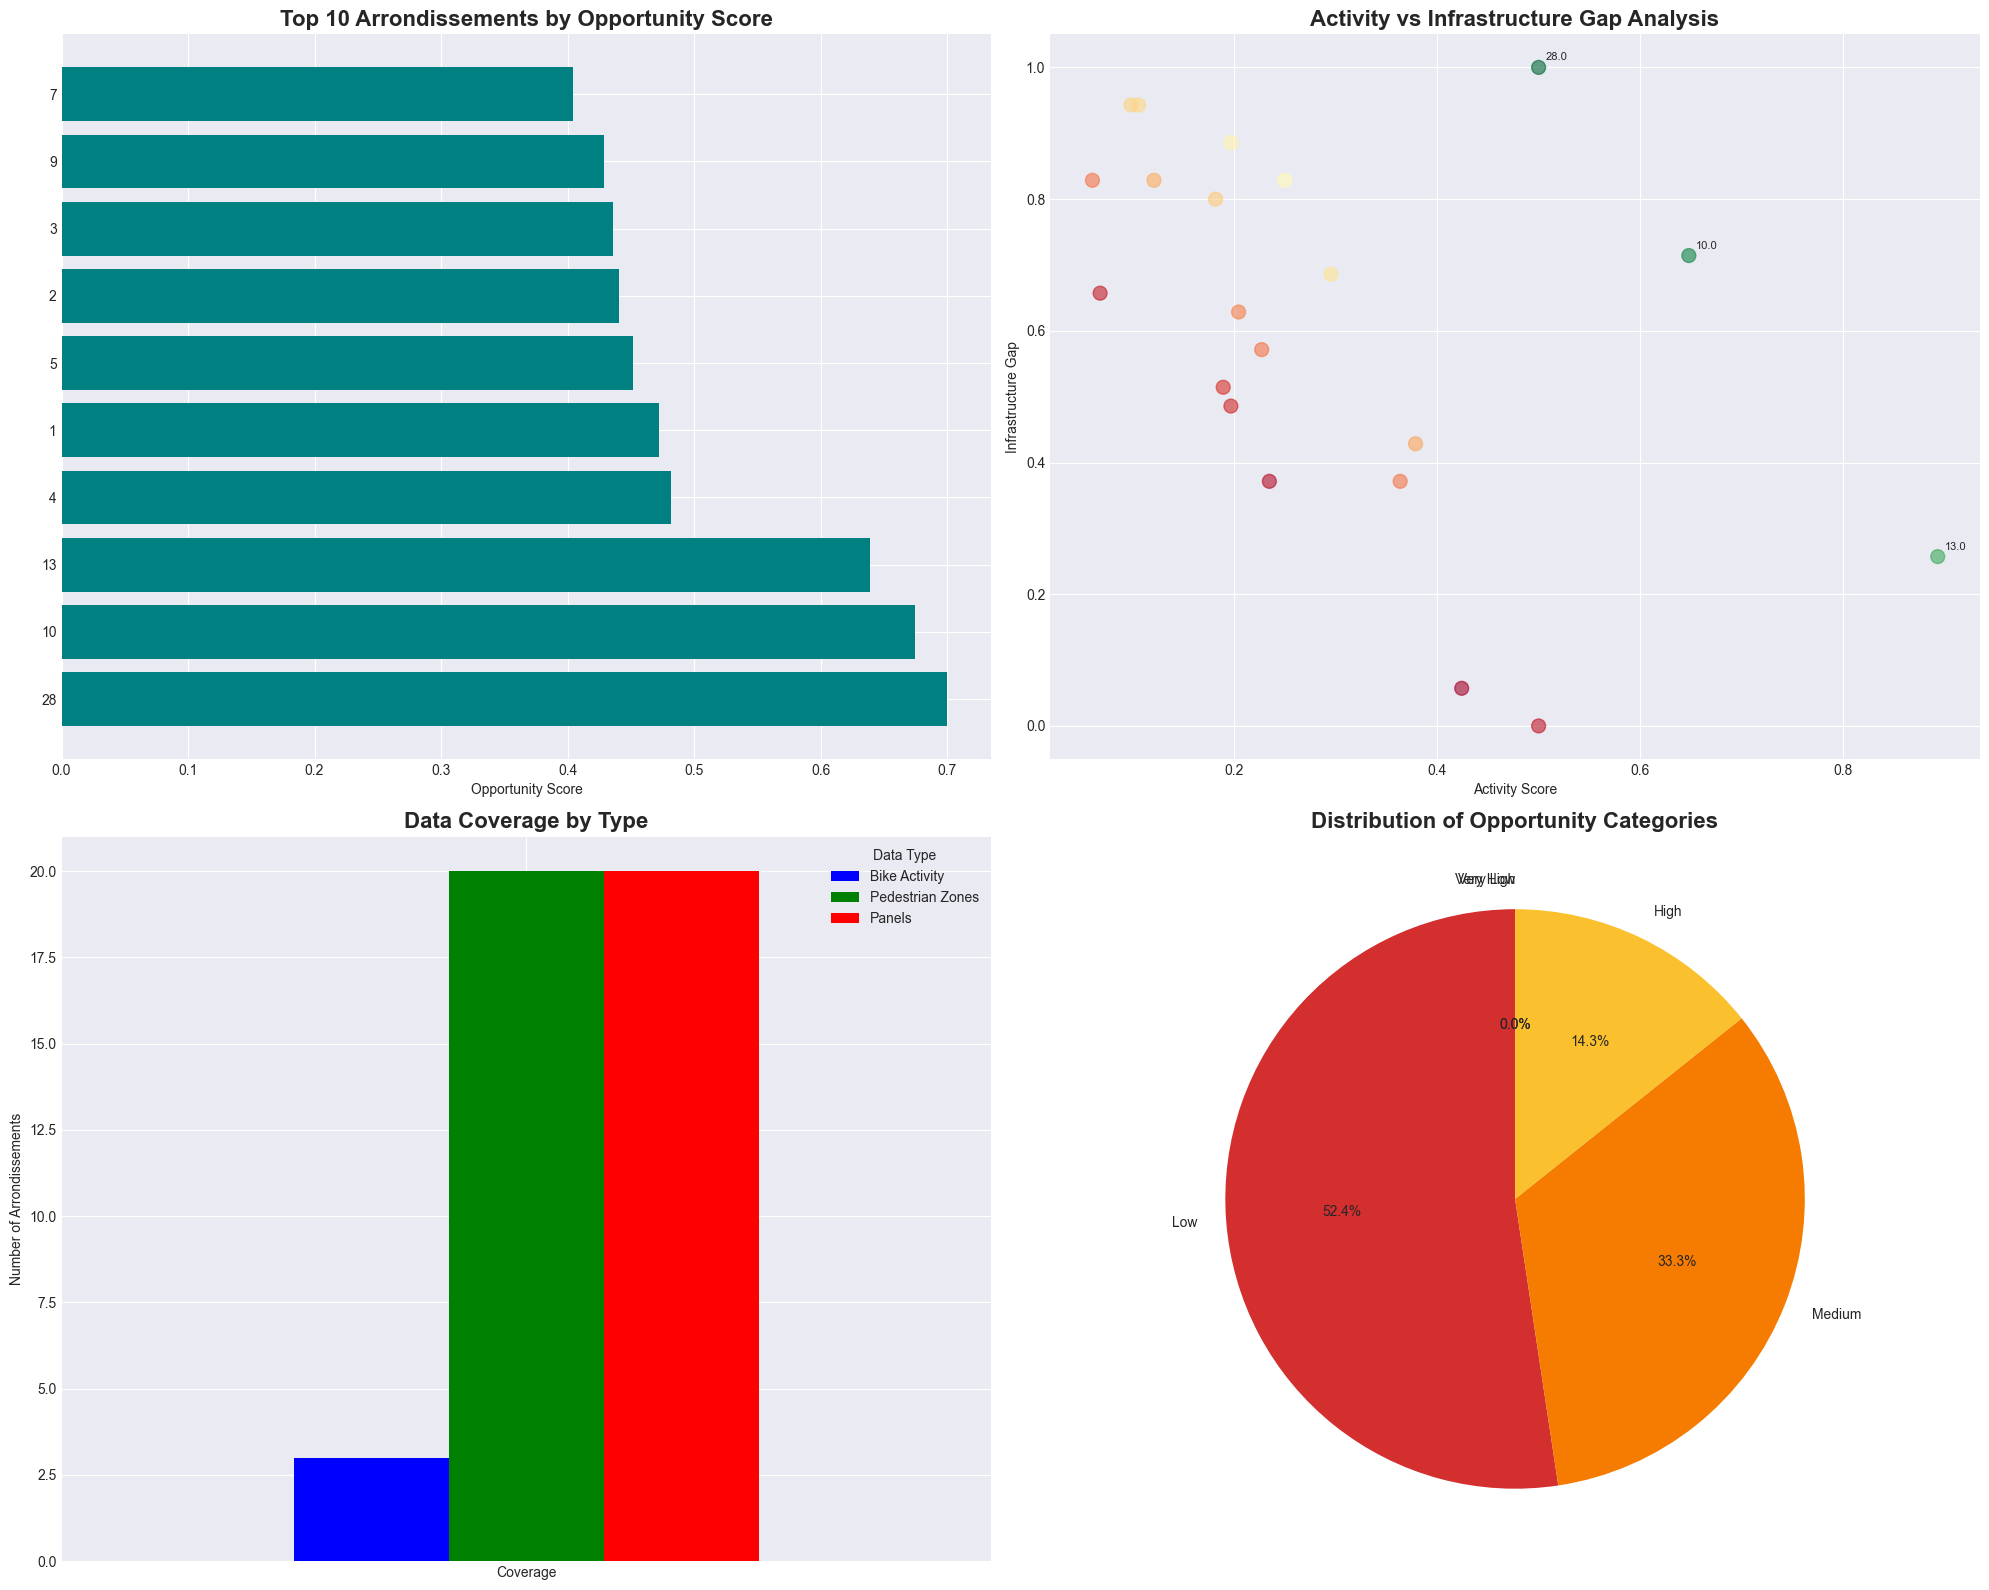

In [15]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Opportunity Scores by Arrondissement
top_10_arr = arr_analysis.head(10)
axes[0, 0].barh(range(len(top_10_arr)), top_10_arr['opportunity_score'], color='teal')
axes[0, 0].set_yticks(range(len(top_10_arr)))
axes[0, 0].set_yticklabels(top_10_arr['arrondissement'])
axes[0, 0].set_xlabel('Opportunity Score')
axes[0, 0].set_title('Top 10 Arrondissements by Opportunity Score', fontsize=16, fontweight='bold')

# 2. Activity vs Infrastructure
axes[0, 1].scatter(arr_analysis['activity_score'], arr_analysis['infrastructure_gap'],
                   s=100, alpha=0.6, c=arr_analysis['opportunity_score'], cmap='RdYlGn')
axes[0, 1].set_xlabel('Activity Score')
axes[0, 1].set_ylabel('Infrastructure Gap')
axes[0, 1].set_title('Activity vs Infrastructure Gap Analysis', fontsize=16, fontweight='bold')

# Add arrondissement labels
for idx, row in arr_analysis.iterrows():
    if row['opportunity_score'] > 0.5:  # Label high opportunity areas
        axes[0, 1].annotate(row['arrondissement'], 
                           (row['activity_score'], row['infrastructure_gap']),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)

# 3. Infrastructure Distribution
data_summary = pd.DataFrame({
    'Bike Activity': [len(arr_analysis[arr_analysis['bike_records'] > 0])],
    'Pedestrian Zones': [len(arr_analysis[arr_analysis['pedestrian_zones'] > 0])],
    'Panels': [len(arr_analysis[arr_analysis['total_panels'] > 0])]
})

data_summary.plot(kind='bar', ax=axes[1, 0], color=['blue', 'green', 'red'])
axes[1, 0].set_title('Data Coverage by Type', fontsize=16, fontweight='bold')
axes[1, 0].set_ylabel('Number of Arrondissements')
axes[1, 0].set_xticklabels(['Coverage'], rotation=0)
axes[1, 0].legend(title='Data Type')

# 4. Opportunity Category Distribution
if 'opportunity_score' in arr_analysis.columns:
    arr_analysis['opportunity_category'] = pd.cut(
        arr_analysis['opportunity_score'],
        bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
        labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
    )
    
    category_counts = arr_analysis['opportunity_category'].value_counts()
    colors = ['#d32f2f', '#f57c00', '#fbc02d', '#689f38', '#388e3c']
    axes[1, 1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', 
                   colors=colors, startangle=90)
    axes[1, 1].set_title('Distribution of Opportunity Categories', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

In [24]:
from IPython.display import IFrame, display
import folium
from folium import plugins
import matplotlib.patches as patches

def create_and_display_opportunity_map(hex_opportunity):
    """Create and display interactive map with hexagons in notebook"""
    
    # Center map on Paris
    paris_center = [48.8566, 2.3522]
    m = folium.Map(location=paris_center, zoom_start=12, tiles='CartoDB positron')
    
    # Filter for active hexagons
    active_hex = hex_opportunity[hex_opportunity['has_activity'] == 1]
    
    # Create feature groups for different categories
    very_high = folium.FeatureGroup(name='Very High Opportunity')
    high = folium.FeatureGroup(name='High Opportunity')
    medium = folium.FeatureGroup(name='Medium Opportunity')
    low = folium.FeatureGroup(name='Low Opportunity')
    
    # Add hexagons by category
    for _, hex in active_hex.iterrows():
        # Determine color based on category
        if hex['opportunity_category'] == 'Very High':
            color = '#1b5e20'
            group = very_high
        elif hex['opportunity_category'] == 'High':
            color = '#388e3c'
            group = high
        elif hex['opportunity_category'] == 'Medium':
            color = '#fbc02d'
            group = medium
        else:
            color = '#f57c00'
            group = low
        
        # Create detailed popup
        popup_html = f"""
        <div style='width: 200px'>
            <h4>{hex['hex_id']}</h4>
            <b>Opportunity Score:</b> {hex['opportunity_score']:.3f}<br>
            <b>Category:</b> {hex['opportunity_category']}<br>
            <hr>
            <b>Activity Metrics:</b><br>
            - Bike Records: {hex['bike_records']:.0f}<br>
            - Pedestrian Zones: {hex['pedestrian_zones']:.0f}<br>
            - Current Panels: {hex['total_panels']:.0f}<br>
            <hr>
            <b>Scores:</b><br>
            - Activity: {hex['activity_score']:.3f}<br>
            - Infrastructure Gap: {hex['infrastructure_gap']:.3f}<br>
            - Rush Hour Ratio: {hex['rush_hour_ratio']:.2%}
        </div>
        """
        
        # Add hexagon marker
        folium.CircleMarker(
            location=[hex['lat'], hex['lon']],
            radius=8 + (hex['opportunity_score'] * 10),
            popup=folium.Popup(popup_html, max_width=300),
            color='black',
            weight=1,
            fillColor=color,
            fillOpacity=0.7
        ).add_to(group)
    
    # Add all groups to map
    very_high.add_to(m)
    high.add_to(m)
    medium.add_to(m)
    low.add_to(m)
    
    # Add existing panels as a separate layer
    if 'latitude' in panels_data.columns:
        panels_group = folium.FeatureGroup(name='Existing Panels')
        for _, panel in panels_data.dropna(subset=['latitude', 'longitude']).iterrows():
            folium.CircleMarker(
                location=[panel['latitude'], panel['longitude']],
                radius=3,
                popup=f"Existing Panel<br>Area: {panel.get('total_area', 'N/A')} m²",
                color='blue',
                weight=1,
                fillColor='blue',
                fillOpacity=0.5
            ).add_to(panels_group)
        panels_group.add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    # Add a heatmap layer
    heat_data = [[row['lat'], row['lon'], row['opportunity_score']] 
                 for _, row in active_hex.iterrows()]
    
    plugins.HeatMap(heat_data, min_opacity=0.3, radius=20, blur=15, 
                    gradient={0.0: 'blue', 0.3: 'cyan', 0.5: 'yellow', 
                             0.7: 'orange', 1.0: 'red'},
                    name='Opportunity Heatmap').add_to(m)
    
    # Save and display
    map_path = '../data/cross_analysis/paris_opportunity_map.html'
    m.save(map_path)
    
    # Display in notebook
    return m

# Create and display map
opportunity_map = create_and_display_opportunity_map(hex_opportunity)
display(opportunity_map)

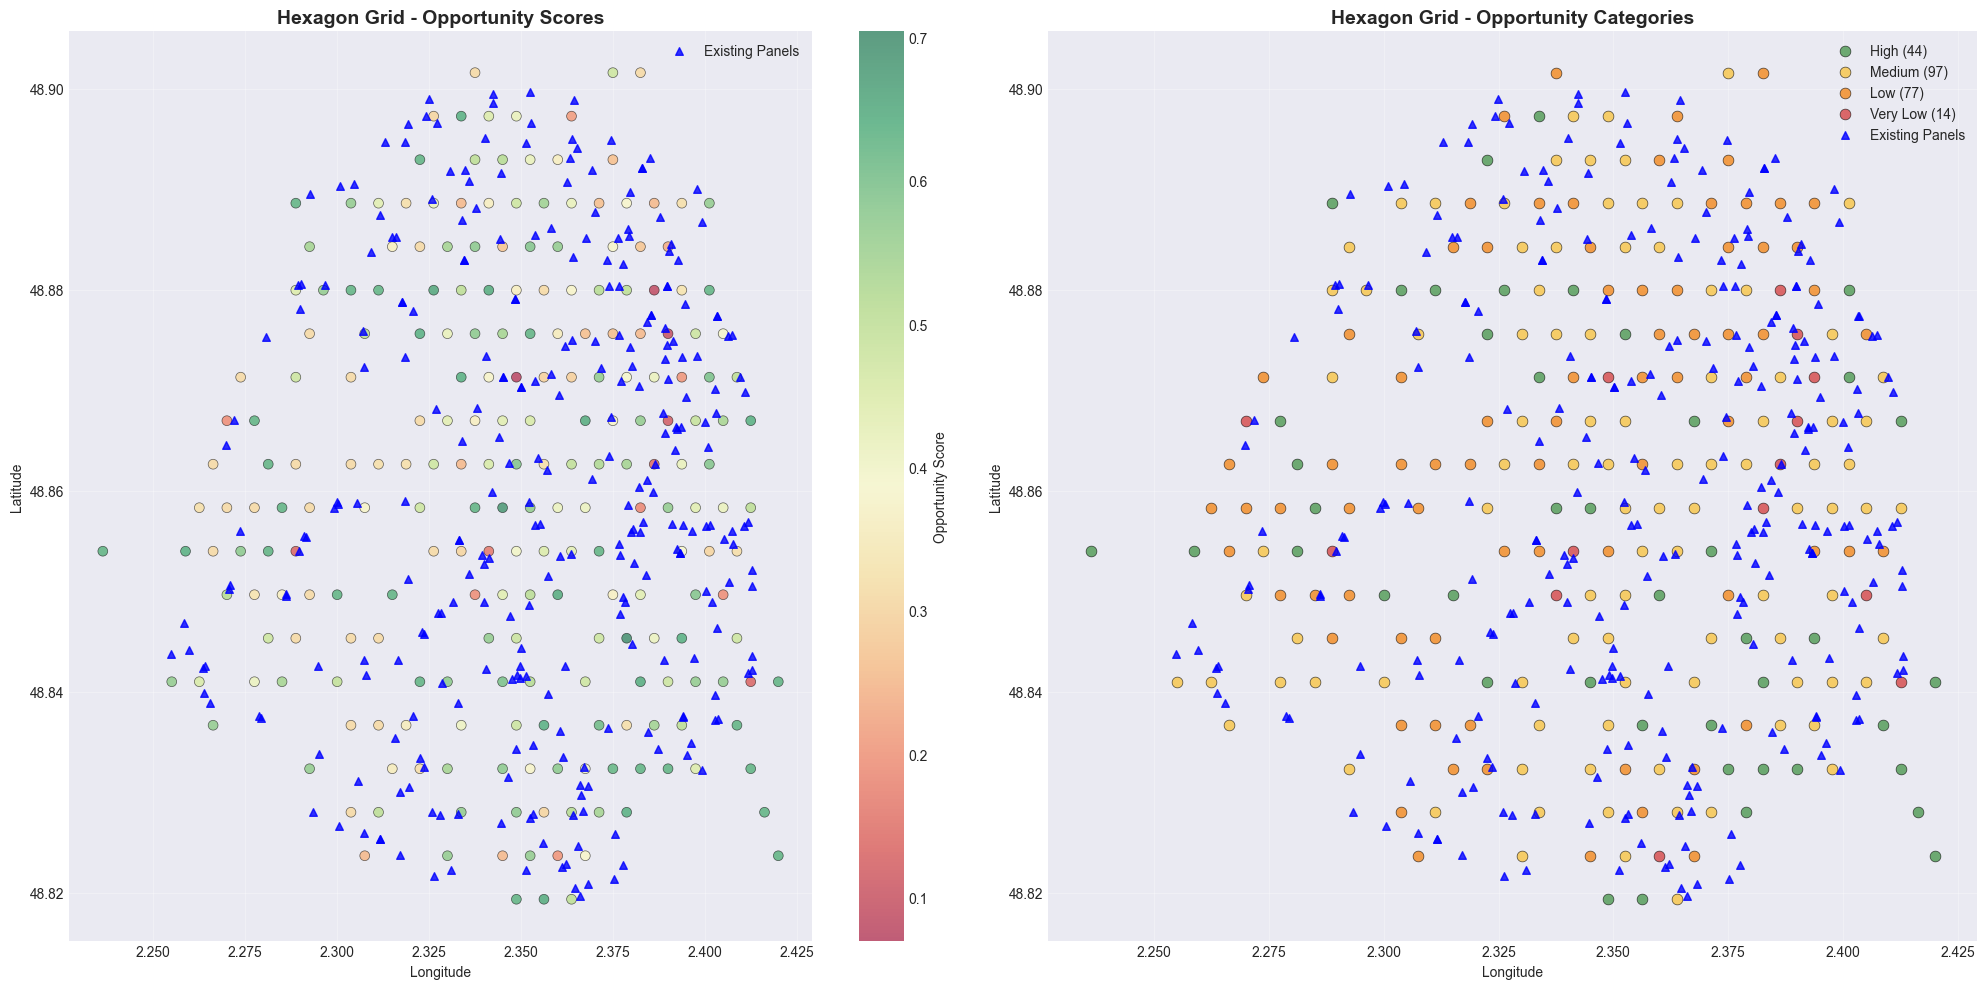


HEXAGON GRID STATISTICS:
Total hexagons: 557
Active hexagons: 232
Hexagon size: ~0.555 km (approximately)

Opportunity distribution:
opportunity_category
Medium       97
Low          77
High         44
Very Low     14
Very High     0
Name: count, dtype: int64


In [25]:
def visualize_hexagon_grid(hex_opportunity, zoom_area=None):
    """Visualize the hexagon grid with opportunity scores"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Filter active hexagons
    active_hex = hex_opportunity[hex_opportunity['has_activity'] == 1]
    
    # Plot 1: All hexagons with activity
    scatter1 = ax1.scatter(active_hex['lon'], active_hex['lat'], 
                          c=active_hex['opportunity_score'], 
                          cmap='RdYlGn', s=50, alpha=0.6, 
                          edgecolors='black', linewidth=0.5)
    
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.set_title('Hexagon Grid - Opportunity Scores', fontsize=14, fontweight='bold')
    
    # Add colorbar
    cbar1 = plt.colorbar(scatter1, ax=ax1)
    cbar1.set_label('Opportunity Score')
    
    # Add grid
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Hexagon categories
    category_colors = {
        'Very High': '#1b5e20',
        'High': '#388e3c',
        'Medium': '#fbc02d',
        'Low': '#f57c00',
        'Very Low': '#d32f2f'
    }
    
    for category, color in category_colors.items():
        cat_data = active_hex[active_hex['opportunity_category'] == category]
        if len(cat_data) > 0:
            ax2.scatter(cat_data['lon'], cat_data['lat'], 
                       color=color, s=60, alpha=0.7, 
                       edgecolors='black', linewidth=0.5,
                       label=f'{category} ({len(cat_data)})')
    
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    ax2.set_title('Hexagon Grid - Opportunity Categories', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    # If we have panels data with coordinates, overlay them
    if 'latitude' in panels_data.columns:
        panel_coords = panels_data.dropna(subset=['latitude', 'longitude'])
        if len(panel_coords) > 0:
            ax1.scatter(panel_coords['longitude'], panel_coords['latitude'], 
                       marker='^', color='blue', s=30, alpha=0.8, 
                       label='Existing Panels')
            ax2.scatter(panel_coords['longitude'], panel_coords['latitude'], 
                       marker='^', color='blue', s=30, alpha=0.8, 
                       label='Existing Panels')
            ax1.legend()
            ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Show hexagon size
    print(f"\nHEXAGON GRID STATISTICS:")
    print(f"Total hexagons: {len(hex_opportunity)}")
    print(f"Active hexagons: {len(active_hex)}")
    print(f"Hexagon size: ~{0.005 * 111} km (approximately)")
    print(f"\nOpportunity distribution:")
    print(active_hex['opportunity_category'].value_counts())

# Visualize hexagon grid
visualize_hexagon_grid(hex_opportunity)

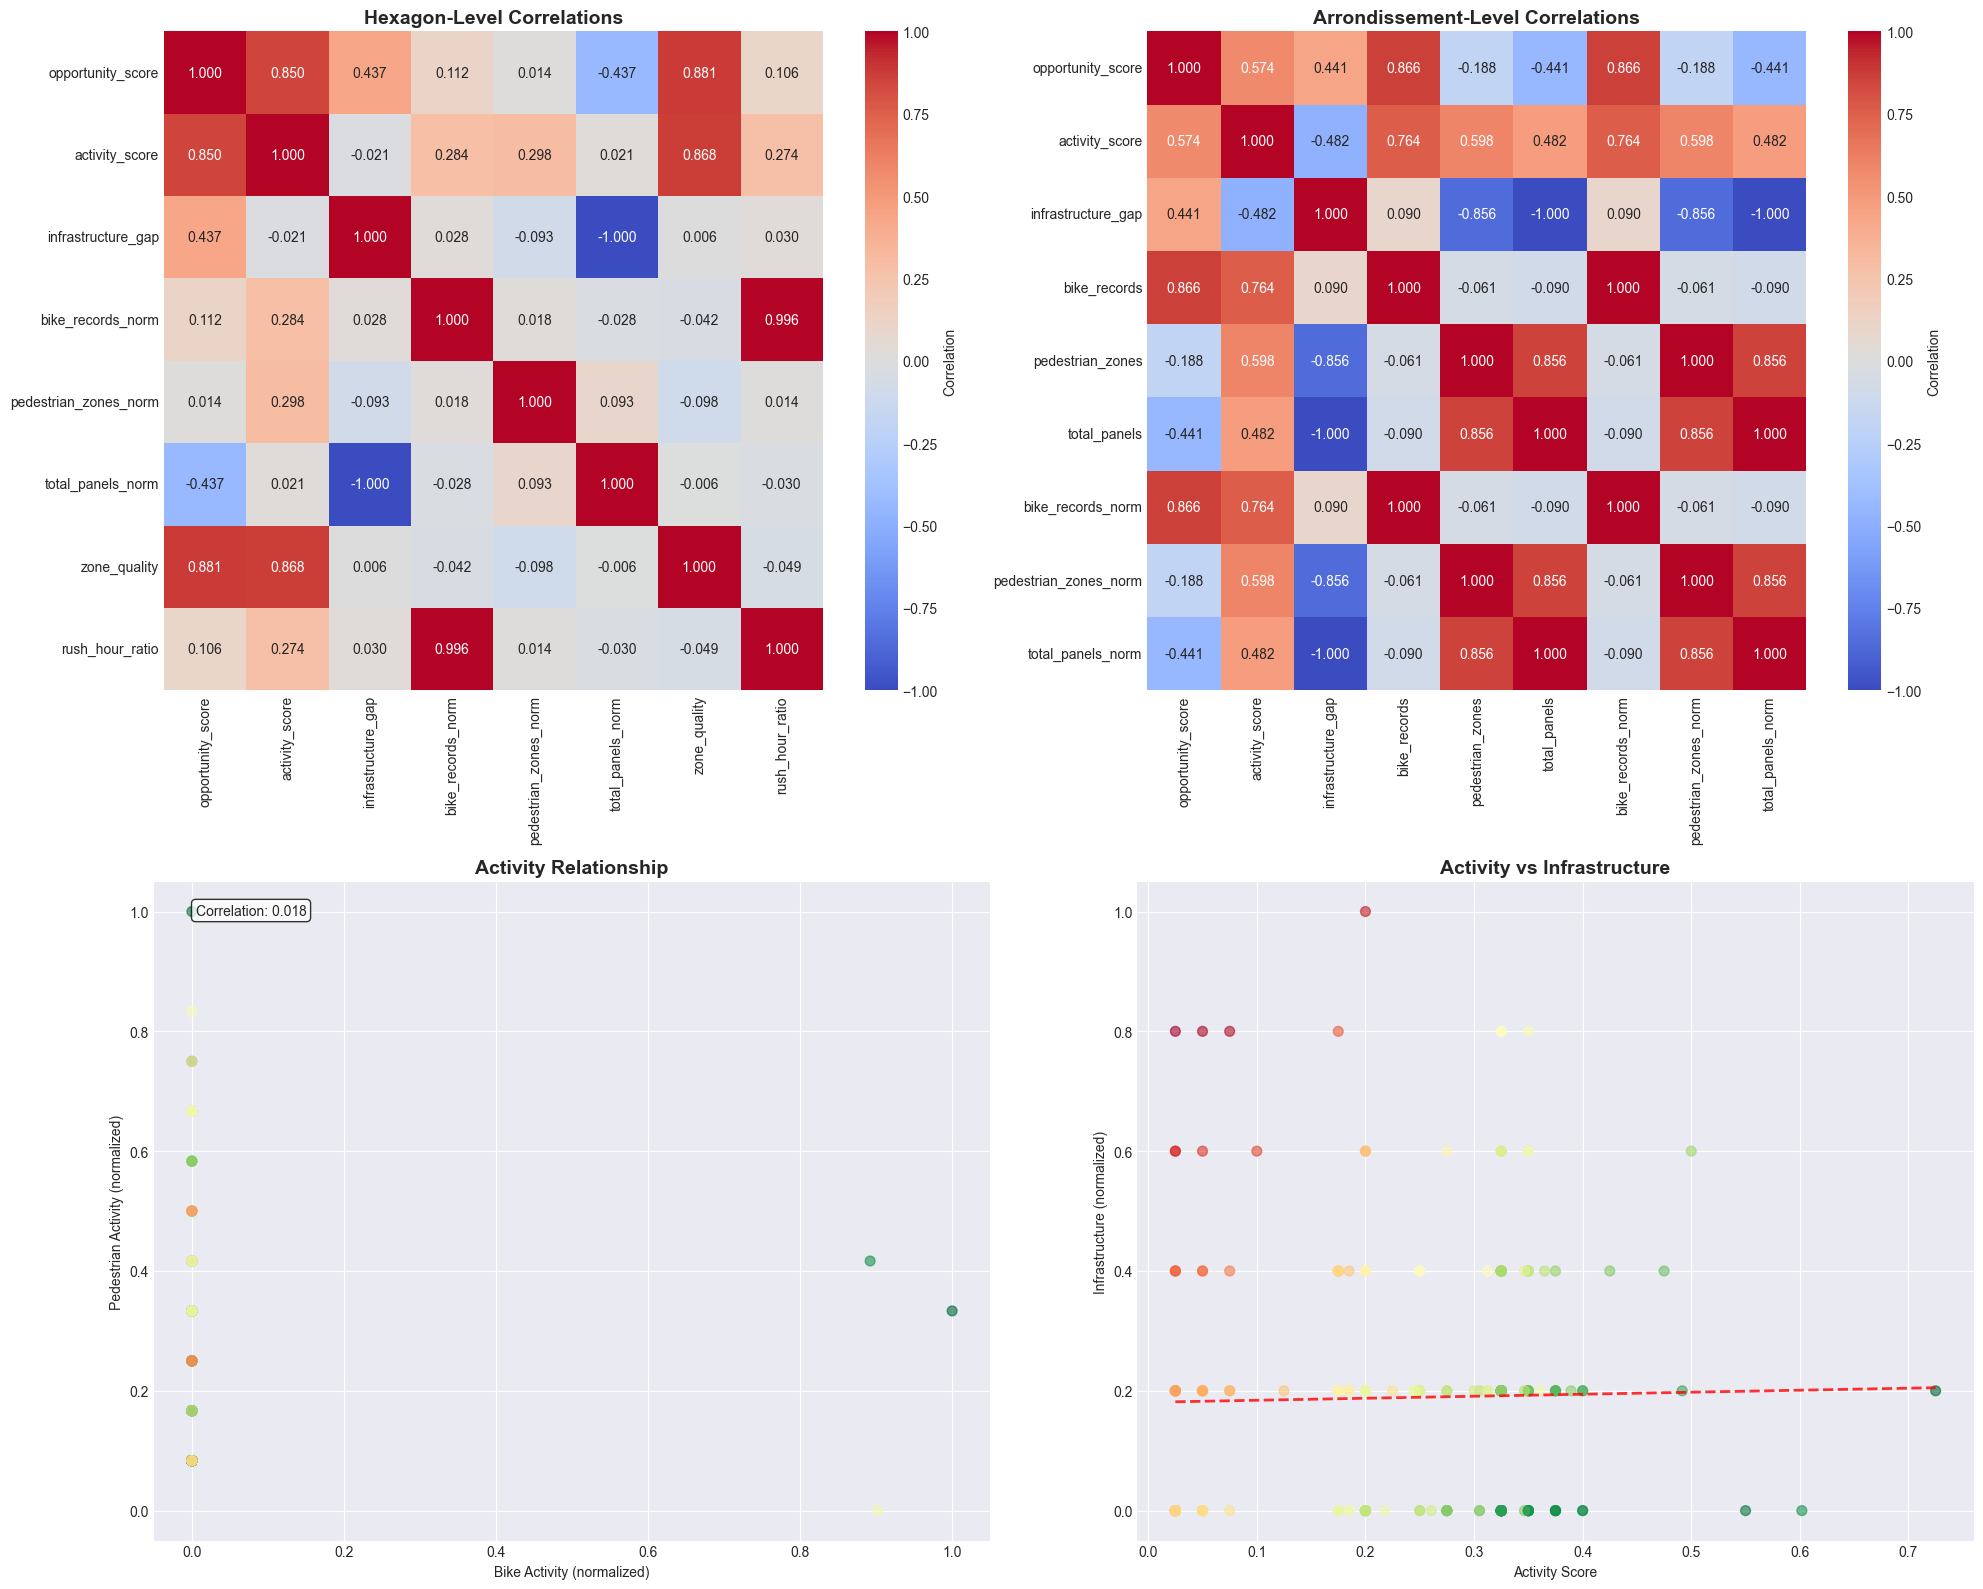


KEY CORRELATIONS:

1. Opportunity Score correlations (Hexagon level):
   - zone_quality: 0.881
   - activity_score: 0.850
   - infrastructure_gap: 0.437
   - bike_records_norm: 0.112
   - rush_hour_ratio: 0.106
   - pedestrian_zones_norm: 0.014
   - total_panels_norm: -0.437

2. Infrastructure Gap insights:
   - Areas with high activity but no infrastructure: 2
   - Average infrastructure gap in high-opportunity areas: 0.982


In [26]:
def create_correlation_heatmaps(hex_opportunity, arr_analysis):
    """Create comprehensive correlation heatmaps"""
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. Hexagon-level correlations
    hex_corr_cols = ['opportunity_score', 'activity_score', 'infrastructure_gap',
                     'bike_records_norm', 'pedestrian_zones_norm', 'total_panels_norm',
                     'zone_quality', 'rush_hour_ratio']
    
    # Filter columns that exist
    hex_corr_cols = [col for col in hex_corr_cols if col in hex_opportunity.columns]
    
    if len(hex_corr_cols) > 2:
        hex_corr = hex_opportunity[hex_opportunity['has_activity'] == 1][hex_corr_cols].corr()
        
        sns.heatmap(hex_corr, annot=True, fmt='.3f', cmap='coolwarm', 
                    center=0, square=True, ax=axes[0,0],
                    cbar_kws={'label': 'Correlation'})
        axes[0,0].set_title('Hexagon-Level Correlations', fontsize=14, fontweight='bold')
    
    # 2. Arrondissement-level correlations
    arr_corr_cols = ['opportunity_score', 'activity_score', 'infrastructure_gap',
                     'bike_records', 'pedestrian_zones', 'total_panels']
    
    # Filter columns that exist
    arr_corr_cols = [col for col in arr_corr_cols if col in arr_analysis.columns]
    
    if len(arr_corr_cols) > 2:
        # Normalize values for correlation
        arr_corr_data = arr_analysis[arr_corr_cols].copy()
        for col in ['bike_records', 'pedestrian_zones', 'total_panels']:
            if col in arr_corr_data.columns:
                max_val = arr_corr_data[col].max()
                if max_val > 0:
                    arr_corr_data[col + '_norm'] = arr_corr_data[col] / max_val
        
        arr_corr = arr_corr_data.corr()
        
        sns.heatmap(arr_corr, annot=True, fmt='.3f', cmap='coolwarm', 
                    center=0, square=True, ax=axes[0,1],
                    cbar_kws={'label': 'Correlation'})
        axes[0,1].set_title('Arrondissement-Level Correlations', fontsize=14, fontweight='bold')
    
    # 3. Activity components relationship
    active_hex = hex_opportunity[hex_opportunity['has_activity'] == 1]
    
    # Scatter plot matrix for key variables
    if len(active_hex) > 0:
        axes[1,0].scatter(active_hex['bike_records_norm'], 
                         active_hex['pedestrian_zones_norm'],
                         c=active_hex['opportunity_score'], 
                         cmap='RdYlGn', s=50, alpha=0.6)
        axes[1,0].set_xlabel('Bike Activity (normalized)')
        axes[1,0].set_ylabel('Pedestrian Activity (normalized)')
        axes[1,0].set_title('Activity Relationship', fontsize=14, fontweight='bold')
        
        # Calculate and display correlation
        if 'bike_records_norm' in active_hex.columns and 'pedestrian_zones_norm' in active_hex.columns:
            corr = active_hex['bike_records_norm'].corr(active_hex['pedestrian_zones_norm'])
            axes[1,0].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                          transform=axes[1,0].transAxes,
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 4. Infrastructure vs Activity
    if len(active_hex) > 0:
        axes[1,1].scatter(active_hex['activity_score'], 
                         active_hex['total_panels_norm'],
                         c=active_hex['opportunity_score'], 
                         cmap='RdYlGn', s=50, alpha=0.6)
        axes[1,1].set_xlabel('Activity Score')
        axes[1,1].set_ylabel('Infrastructure (normalized)')
        axes[1,1].set_title('Activity vs Infrastructure', fontsize=14, fontweight='bold')
        
        # Add trend line
        if active_hex['activity_score'].std() > 0:
            z = np.polyfit(active_hex['activity_score'], active_hex['total_panels_norm'], 1)
            p = np.poly1d(z)
            axes[1,1].plot(sorted(active_hex['activity_score']), 
                          p(sorted(active_hex['activity_score'])), 
                          "r--", alpha=0.8, linewidth=2)
    
    plt.tight_layout()
    plt.show()
    
    # Print key correlations
    print("\nKEY CORRELATIONS:")
    if len(hex_corr_cols) > 2:
        print("\n1. Opportunity Score correlations (Hexagon level):")
        opp_corrs = hex_corr['opportunity_score'].sort_values(ascending=False)
        for var, corr in opp_corrs.items():
            if var != 'opportunity_score':
                print(f"   - {var}: {corr:.3f}")
    
    print("\n2. Infrastructure Gap insights:")
    print(f"   - Areas with high activity but no infrastructure: {len(active_hex[(active_hex['activity_score'] > 0.5) & (active_hex['total_panels'] == 0)])}")
    print(f"   - Average infrastructure gap in high-opportunity areas: {active_hex[active_hex['opportunity_category'].isin(['High', 'Very High'])]['infrastructure_gap'].mean():.3f}")

# Create correlation heatmaps
create_correlation_heatmaps(hex_opportunity, arr_analysis)

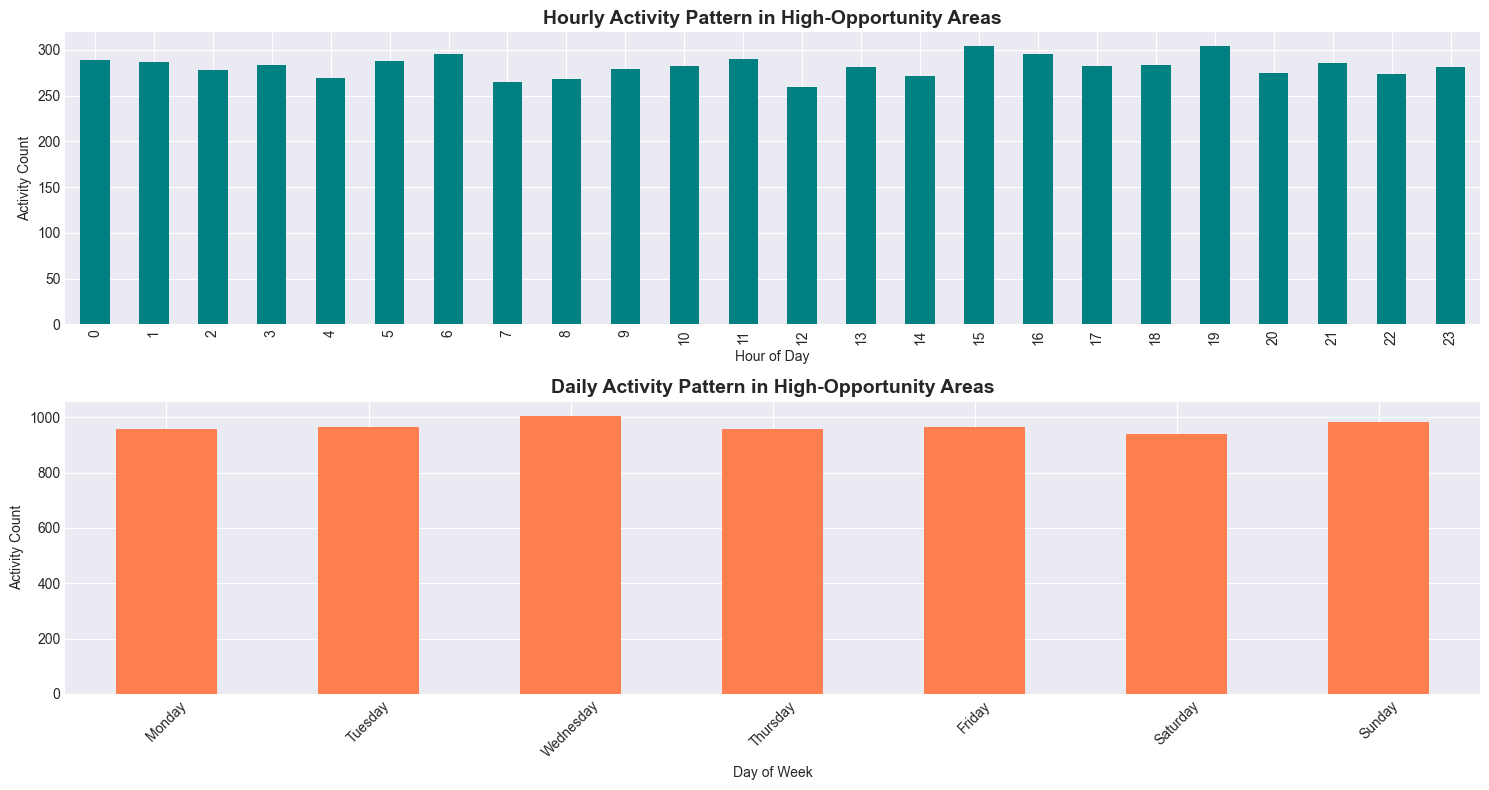


PEAK ACTIVITY TIME: 15:00 with 304 activities
RUSH HOUR ACTIVITY: 24.8% of total activity occurs during rush hours


In [19]:
def analyze_temporal_patterns(bike_data, hex_opportunity):
    """Analyze temporal patterns for high-opportunity areas"""
    
    # Get high opportunity hexagons
    high_opp_hexes = hex_opportunity[
        hex_opportunity['opportunity_category'].isin(['High', 'Very High'])
    ]['hex_id'].tolist()
    
    # Filter bike data for these hexagons
    if 'hex_id' in bike_data.columns and len(high_opp_hexes) > 0:
        high_opp_bike = bike_data[bike_data['hex_id'].isin(high_opp_hexes)]
        
        if len(high_opp_bike) > 0 and 'hour' in high_opp_bike.columns:
            # Create hour x day matrix
            plt.figure(figsize=(15, 8))
            
            # Hourly pattern
            hourly_pattern = high_opp_bike.groupby('hour').size()
            
            plt.subplot(2, 1, 1)
            hourly_pattern.plot(kind='bar', color='teal')
            plt.title('Hourly Activity Pattern in High-Opportunity Areas', fontsize=14, fontweight='bold')
            plt.xlabel('Hour of Day')
            plt.ylabel('Activity Count')
            
            # Day of week pattern if available
            if 'weekday' in high_opp_bike.columns:
                plt.subplot(2, 1, 2)
                day_pattern = high_opp_bike['weekday'].value_counts()
                day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
                day_pattern = day_pattern.reindex([d for d in day_order if d in day_pattern.index])
                day_pattern.plot(kind='bar', color='coral')
                plt.title('Daily Activity Pattern in High-Opportunity Areas', fontsize=14, fontweight='bold')
                plt.xlabel('Day of Week')
                plt.ylabel('Activity Count')
                plt.xticks(rotation=45)
            
            plt.tight_layout()
            plt.show()
            
            # Identify peak times
            peak_hour = hourly_pattern.idxmax()
            peak_count = hourly_pattern.max()
            print(f"\nPEAK ACTIVITY TIME: {peak_hour}:00 with {peak_count} activities")
            
            # Rush hour analysis
            rush_hours = [7, 8, 9, 17, 18, 19]
            rush_activity = hourly_pattern[hourly_pattern.index.isin(rush_hours)].sum()
            total_activity = hourly_pattern.sum()
            rush_percentage = (rush_activity / total_activity) * 100
            
            print(f"RUSH HOUR ACTIVITY: {rush_percentage:.1f}% of total activity occurs during rush hours")
    else:
        # Use arrondissement-level data instead
        print("Using arrondissement-level temporal analysis...")
        
        # Show top opportunities by time if we have temporal data
        if 'hour' in bike_data.columns:
            plt.figure(figsize=(12, 6))
            hourly_all = bike_data.groupby('hour').size()
            hourly_all.plot(kind='bar', color='steelblue')
            plt.title('Overall Hourly Activity Pattern', fontsize=14, fontweight='bold')
            plt.xlabel('Hour of Day')
            plt.ylabel('Activity Count')
            plt.show()

# Run temporal analysis
analyze_temporal_patterns(bike_data, hex_opportunity)

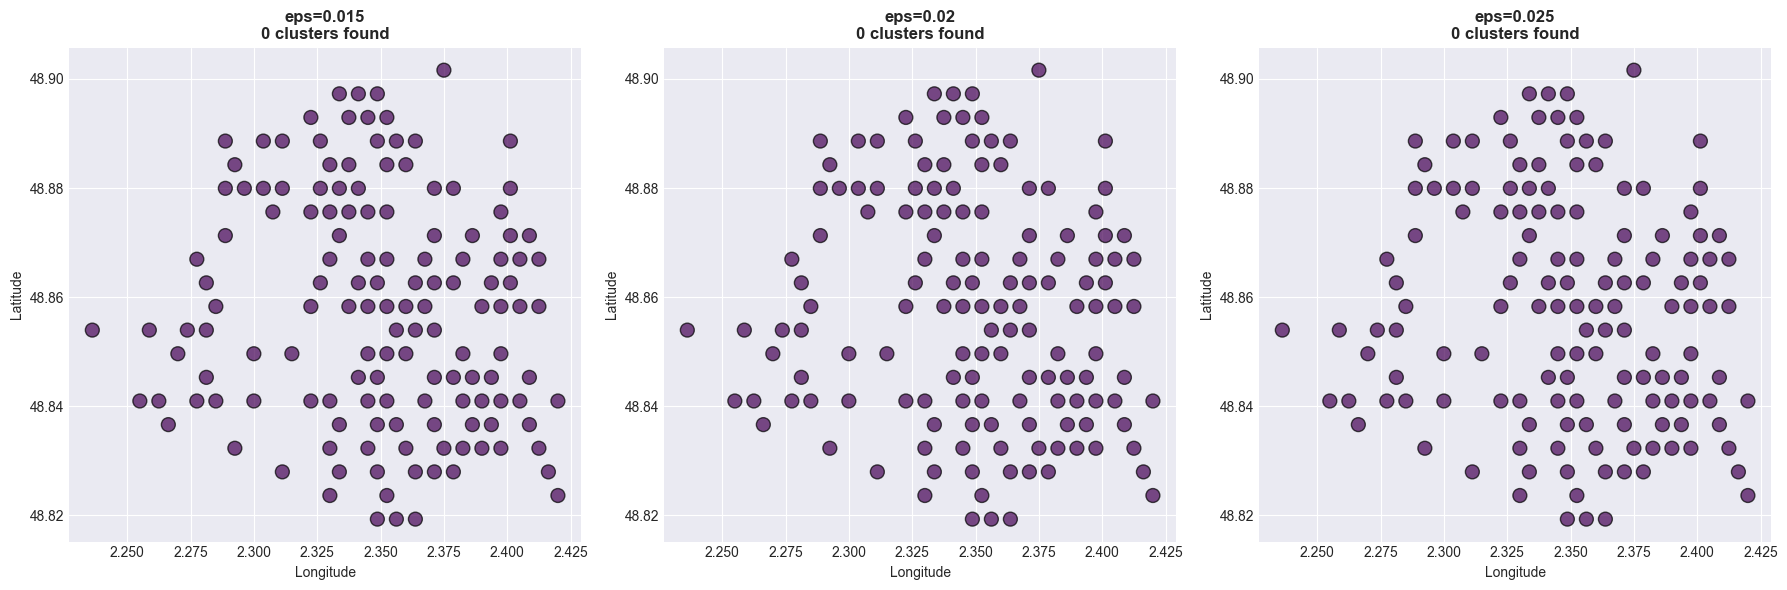

In [27]:
def perform_spatial_clustering(hex_opportunity, min_samples=2, eps_range=[0.01, 0.02, 0.03]):
    """Perform clustering with different parameters and visualize"""
    
    # Filter high opportunity hexagons
    high_opp = hex_opportunity[
        (hex_opportunity['opportunity_score'] > 0.4) & 
        (hex_opportunity['has_activity'] == 1)
    ].copy()
    
    if len(high_opp) < min_samples:
        print(f"Not enough high-opportunity hexagons ({len(high_opp)})")
        return hex_opportunity
    
    # Try different eps values
    fig, axes = plt.subplots(1, len(eps_range), figsize=(6*len(eps_range), 6))
    if len(eps_range) == 1:
        axes = [axes]
    
    best_eps = None
    best_n_clusters = 0
    
    for i, eps in enumerate(eps_range):
        # Prepare and scale coordinates
        coords = high_opp[['lat', 'lon']].values
        scaler = StandardScaler()
        coords_scaled = scaler.fit_transform(coords)
        
        # Perform clustering
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coords_scaled)
        high_opp[f'cluster_{eps}'] = clustering.labels_
        
        # Count clusters (excluding noise)
        n_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
        
        # Visualize
        scatter = axes[i].scatter(high_opp['lon'], high_opp['lat'], 
                                 c=clustering.labels_, cmap='viridis', 
                                 s=100, alpha=0.7, edgecolors='black')
        
        axes[i].set_title(f'eps={eps}\n{n_clusters} clusters found', fontweight='bold')
        axes[i].set_xlabel('Longitude')
        axes[i].set_ylabel('Latitude')
        
        # Mark cluster centers
        for cluster_id in set(clustering.labels_):
            if cluster_id != -1:
                cluster_points = high_opp[clustering.labels_ == cluster_id]
                center_lat = cluster_points['lat'].mean()
                center_lon = cluster_points['lon'].mean()
                axes[i].scatter(center_lon, center_lat, c='red', s=200, 
                               marker='*', edgecolors='black', linewidth=2)
        
        # Track best parameters
        if n_clusters > best_n_clusters and n_clusters < len(high_opp)/2:
            best_eps = eps
            best_n_clusters = n_clusters
    
    plt.tight_layout()
    plt.show()
    
    # Use best parameters for final clustering
    if best_eps and best_n_clusters > 0:
        print(f"\nBest clustering: eps={best_eps} with {best_n_clusters} clusters")
        
        # Apply best clustering to main dataframe
        coords = high_opp[['lat', 'lon']].values
        scaler = StandardScaler()
        coords_scaled = scaler.fit_transform(coords)
        best_clustering = DBSCAN(eps=best_eps, min_samples=min_samples).fit(coords_scaled)
        
        high_opp['final_cluster'] = best_clustering.labels_
        
        # Merge back
        hex_opportunity = hex_opportunity.merge(
            high_opp[['hex_id', 'final_cluster']], 
            on='hex_id', 
            how='left'
        )
        hex_opportunity['cluster_id'] = hex_opportunity['final_cluster'].fillna(-1).astype(int)
        hex_opportunity = hex_opportunity.drop(columns=['final_cluster'])
        
        # Cluster analysis
        cluster_analysis = high_opp[high_opp['final_cluster'] != -1].groupby('final_cluster').agg({
            'opportunity_score': ['mean', 'std', 'count'],
            'bike_records': 'sum',
            'pedestrian_zones': 'sum',
            'total_panels': 'sum',
            'infrastructure_gap': 'mean'
        }).round(3)
        
        print("\nCLUSTER ANALYSIS:")
        print(cluster_analysis)
        
        # Create cluster summary visualization
        fig, ax = plt.subplots(figsize=(10, 6))
        
        cluster_summary = high_opp[high_opp['final_cluster'] != -1].groupby('final_cluster').agg({
            'opportunity_score': 'mean',
            'hex_id': 'count'
        }).reset_index()
        
        bars = ax.bar(cluster_summary['final_cluster'].astype(str), 
                      cluster_summary['opportunity_score'],
                      color='teal', alpha=0.7)
        
        # Add count labels
        for bar, count in zip(bars, cluster_summary['hex_id']):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{count} hexagons',
                    ha='center', va='bottom')
        
        ax.set_xlabel('Cluster ID')
        ax.set_ylabel('Average Opportunity Score')
        ax.set_title('Opportunity Clusters Summary', fontsize=14, fontweight='bold')
        plt.show()
    
    return hex_opportunity

# Perform improved clustering
hex_opportunity = perform_spatial_clustering(hex_opportunity, min_samples=3, eps_range=[0.015, 0.02, 0.025])

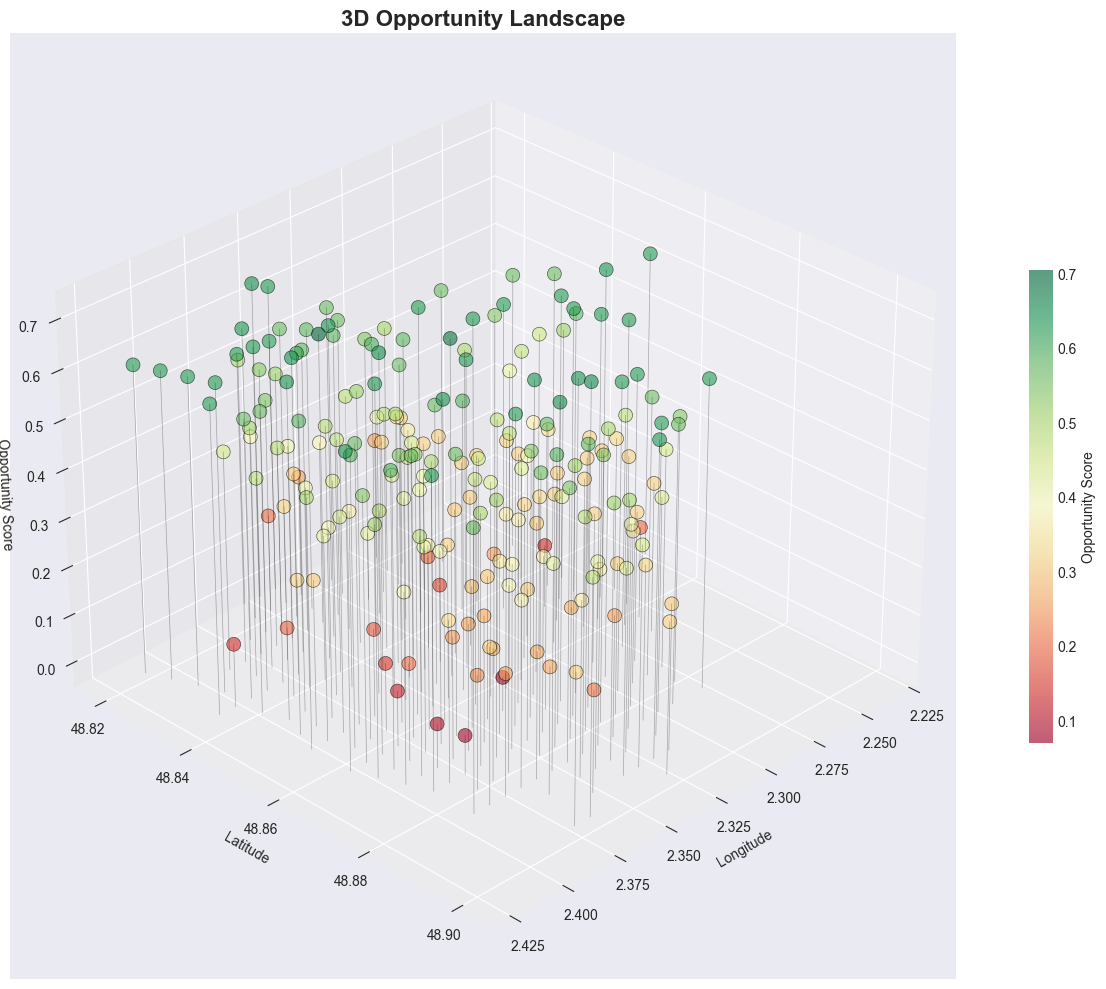

In [28]:
def create_3d_opportunity_landscape(hex_opportunity):
    """Create 3D visualization of opportunity landscape"""
    
    from mpl_toolkits.mplot3d import Axes3D
    
    active_hex = hex_opportunity[hex_opportunity['has_activity'] == 1]
    
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create 3D scatter plot
    scatter = ax.scatter(active_hex['lon'], 
                        active_hex['lat'], 
                        active_hex['opportunity_score'],
                        c=active_hex['opportunity_score'], 
                        cmap='RdYlGn',
                        s=100, 
                        alpha=0.6,
                        edgecolors='black',
                        linewidth=0.5)
    
    # Add vertical lines to ground
    for _, hex in active_hex.iterrows():
        ax.plot([hex['lon'], hex['lon']], 
                [hex['lat'], hex['lat']], 
                [0, hex['opportunity_score']], 
                'k-', alpha=0.3, linewidth=0.5)
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Opportunity Score')
    ax.set_title('3D Opportunity Landscape', fontsize=16, fontweight='bold')
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label='Opportunity Score', shrink=0.5)
    
    # Set viewing angle
    ax.view_init(elev=30, azim=45)
    
    plt.tight_layout()
    plt.show()

# Create 3D visualization
create_3d_opportunity_landscape(hex_opportunity)

In [34]:
# Simple export for Power BI and next steps
import os

# Create output directory
output_dir = '../data/cross_analysis/'
os.makedirs(output_dir, exist_ok=True)

# 1. Export main Power BI dataset
powerbi_data = hex_opportunity[hex_opportunity['has_activity'] == 1][[
    'hex_id', 'lat', 'lon', 
    'opportunity_score', 'opportunity_category',
    'bike_records', 'pedestrian_zones', 'total_panels',
    'activity_score', 'infrastructure_gap', 'zone_quality',
    'rush_hour_ratio'
]].copy()

# Add calculated fields for Power BI
powerbi_data['opportunity_rank'] = powerbi_data['opportunity_score'].rank(ascending=False)
powerbi_data['has_infrastructure'] = (powerbi_data['total_panels'] > 0).astype(int)

# Export
powerbi_data.to_csv(f'{output_dir}powerbi_data.csv', index=False)
print(f"✅ Exported {len(powerbi_data)} active hexagons to powerbi_data.csv")

# 2. Export arrondissement summary
arr_analysis.to_csv(f'{output_dir}arrondissement_summary.csv', index=False)
print(f"✅ Exported {len(arr_analysis)} arrondissements to arrondissement_summary.csv")

# 3. Quick stats
print("\n📊 Quick Stats for Power BI:")
print(f"- Total opportunities: {len(powerbi_data)}")
print(f"- High opportunities: {len(powerbi_data[powerbi_data['opportunity_category'] == 'High'])}")
print(f"- Areas without panels: {len(powerbi_data[powerbi_data['total_panels'] == 0])}")
print(f"- Top arrondissement: {arr_analysis.iloc[0]['arrondissement']}")

✅ Exported 232 active hexagons to powerbi_data.csv
✅ Exported 21 arrondissements to arrondissement_summary.csv

📊 Quick Stats for Power BI:
- Total opportunities: 232
- High opportunities: 44
- Areas without panels: 100
- Top arrondissement: 28
